In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

### Define and build a feedforward network

In [2]:
# define a transform to normalize data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ])

# download and load the training data
trainset = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [3]:
# build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# define the loss
criterion = nn.CrossEntropyLoss()

# get data
images, labels = next(iter(trainloader))
# flatten images
images = images.view(images.shape[0], -1)

# forward pass, get logits
logits = model(images)

# calculate loss with logits and labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3214, grad_fn=<NllLossBackward>)


Exercise: build a model that returns the log-softmax as the output and calculate the loss using the negative log likelihood loss


### Calculate loss

In [4]:
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

criterion = nn.NLLLoss()

images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logits = model(images)
loss = criterion(logits, labels)

print(loss)

tensor(2.3032, grad_fn=<NllLossBackward>)


### Backpropagation using autograd
Autograd is a module to automatically calculate the gradients of tensors
- for this, you'll need to have requires_grad = True    on a tensor so that PyTorch will keep track of operations on a tensor and calculate the gradients
- by default it is true, to turn off, torch.set_grad_enabled(False)

In [5]:
x = torch.randn(2,2, requires_grad=True)
print(x)

tensor([[-0.6506, -0.7098],
        [ 0.0264, -0.0479]], requires_grad=True)


In [6]:
print(x.grad)

None


Currently, there are no gradients set (as seen in cell above). To calculate the gradients, you need to run the .backward method on a variable


In [7]:
print('Before backward pass: \n', model[0].weight.grad)

loss.backward()

print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        [-0.0002, -0.0002, -0.0002,  ..., -0.0002, -0.0002, -0.0002],
        [ 0.0013,  0.0013,  0.0013,  ...,  0.0013,  0.0013,  0.0013],
        ...,
        [ 0.0006,  0.0006,  0.0006,  ...,  0.0006,  0.0006,  0.0006],
        [-0.0033, -0.0033, -0.0033,  ..., -0.0033, -0.0033, -0.0033],
        [ 0.0014,  0.0014,  0.0014,  ...,  0.0014,  0.0014,  0.0014]])


### Optimizer
- this package will update the weights with gradients

In [8]:
from torch import optim

# optimizers require parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

General process:
1. make a forward pass through network: nn.Sequential()
2. calculate loss with network output: nn.NLLLoss(logits, labels)
3. perform backward pass with loss.backward() to calculate gradients
4. step with optimizer to update the weights

loop until satisfactory loss


### One training step:

In [9]:
print('Initial weights - ', model[0].weight)

images, labels = next(iter(trainloader))
images.resize_(64, 784)

# clear gradients, because they are accumulated
optimizer.zero_grad()

# forawrd pass, backward pass, update weights
output = model(images)
loss = criterion(output, labels)
loss.backward()
print('Gradient  -', model[0].weight.grad)

Initial weights -  Parameter containing:
tensor([[ 0.0184, -0.0115,  0.0199,  ..., -0.0251,  0.0303, -0.0120],
        [ 0.0255, -0.0247,  0.0001,  ..., -0.0144,  0.0163,  0.0213],
        [ 0.0186, -0.0026, -0.0095,  ..., -0.0220,  0.0059, -0.0039],
        ...,
        [-0.0300, -0.0080,  0.0151,  ..., -0.0011, -0.0192,  0.0162],
        [ 0.0242,  0.0160,  0.0303,  ...,  0.0175,  0.0254,  0.0305],
        [ 0.0306,  0.0236,  0.0309,  ..., -0.0220,  0.0331,  0.0172]],
       requires_grad=True)
Gradient  - tensor([[-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0003],
        [ 0.0002,  0.0002,  0.0002,  ...,  0.0002,  0.0002,  0.0002],
        [-0.0005, -0.0005, -0.0005,  ..., -0.0005, -0.0005, -0.0005],
        ...,
        [-0.0071, -0.0071, -0.0071,  ..., -0.0071, -0.0071, -0.0071],
        [ 0.0033,  0.0033,  0.0033,  ...,  0.0033,  0.0033,  0.0033],
        [-0.0000, -0.0000, -0.0000,  ..., -0.0000, -0.0000, -0.0000]])


In [10]:
# take an update step and view the new weights
optimizer.step()
print('Updated weights - ', model[0].weight)

Updated weights -  Parameter containing:
tensor([[ 0.0184, -0.0115,  0.0199,  ..., -0.0251,  0.0303, -0.0120],
        [ 0.0255, -0.0247,  0.0001,  ..., -0.0144,  0.0163,  0.0213],
        [ 0.0186, -0.0026, -0.0095,  ..., -0.0220,  0.0059, -0.0039],
        ...,
        [-0.0300, -0.0079,  0.0152,  ..., -0.0011, -0.0191,  0.0163],
        [ 0.0242,  0.0160,  0.0302,  ...,  0.0174,  0.0254,  0.0304],
        [ 0.0306,  0.0236,  0.0309,  ..., -0.0220,  0.0331,  0.0172]],
       requires_grad=True)


### Training entire image set
Need to loop through algorithm.
- Each pass through the dataset is called an epoch
- loop through trainloader to get training batches
- each batch we'll do a training pass to calculate the loss, do a backwards pass and update the weight

In [13]:
# feedforward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10),
                      nn.LogSoftmax(dim=1))

# loss function
criterion = nn.NLLLoss()
# update the model's weights with gradients
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5 # why 5?
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
        
        # clear gradients between training passes
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 1.8920165837954865
Training loss: 0.8326479111716691
Training loss: 0.5251231840742168
Training loss: 0.42768748363515713
Training loss: 0.38100168069224877


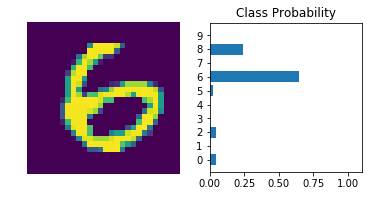

In [16]:
# test out an image
%matplotlib inline
import helper

images, labels = next(iter(trainloader))

img = images[0].view(1, 784)
# turn off gradients to speed up this part
with torch.no_grad():
    logits = model(img)
    
# output of network are logits; take softmax for probability
ps = F.softmax(logits, dim=1)
helper.view_classify(img.view(1, 28, 28), ps)